HAND is ready to train
['one', 'two']


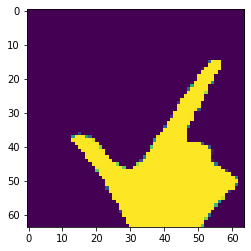

<class 'list'> <class 'list'>
Epoch 1/15
32/32 [==============================] - 1s 45ms/step - loss: 0.9072 - accuracy: 0.4940
Epoch 2/15
32/32 [==============================] - 1s 46ms/step - loss: 0.8024 - accuracy: 0.4980
Epoch 3/15
32/32 [==============================] - 1s 46ms/step - loss: 0.7635 - accuracy: 0.5040
Epoch 4/15
32/32 [==============================] - 1s 46ms/step - loss: 0.7291 - accuracy: 0.5230
Epoch 5/15
32/32 [==============================] - 2s 49ms/step - loss: 0.5392 - accuracy: 0.7310
Epoch 6/15
32/32 [==============================] - 2s 48ms/step - loss: 0.3701 - accuracy: 0.8560
Epoch 7/15
32/32 [==============================] - 2s 48ms/step - loss: 0.2799 - accuracy: 0.9090
Epoch 8/15
32/32 [==============================] - 2s 48ms/step - loss: 0.2071 - accuracy: 0.9330
Epoch 9/15
32/32 [==============================] - 2s 49ms/step - loss: 0.1554 - accuracy: 0.9550
Epoch 10/15
32/32 [==============================] - 2s 48ms/step - loss: 0.139

In [1]:
import numpy as np  
import cv2
import random
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

class HAND:
    def __init__(self):
        self.model = None
        self.size = (64, 64)
        self.size_reshape = (64, 64, 1)
        print('HAND is ready to train')

    def preprocessing(self):
        IMAGE_PATH = 'D:\\datafortrain'
        tag = os.listdir(IMAGE_PATH)
        print(tag)
        training_src = []
        for index, folder in enumerate(tag):
            output = np.array([0 for i in range(0, len(tag))])
            output[index] = 1
            for file_image in os.listdir(os.path.join(IMAGE_PATH, folder)):
                image = cv2.imread(os.path.join(IMAGE_PATH, folder, file_image), cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, self.size).reshape(self.size_reshape)
                training_src.append([image, output])
        random.shuffle(training_src)
        training_src = np.array(training_src)
        x_train = list(training_src[:,0])
        y_train = list(training_src[:,1])
        plt.imshow(x_train[0])
        plt.show()
        return (x_train, y_train)
        
    def train(self, x, y):
        # Phần preprocessing sai nên hàm này vẫn chưa chạy được
        self.model = Sequential()
        self.model.add(Conv2D(32,(3,3),activation='sigmoid',input_shape=self.size_reshape))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(32,(3,3),activation='sigmoid'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='sigmoid'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(2, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
        self.model.fit(x,y,epochs=15, batch_size=32, verbose=1)

    def predict(self, src):
        return self.model.predict(src)

hand = HAND()
x_train, y_train = hand.preprocessing()
# for i in range(0, len(x_train)):
#     x_train[0] = x_train[0].reshape((280, 280, 1)).astype(np.float32)
# print(x_train.shape)
print(type(x_train), type(y_train))
hand.train(np.array(x_train), np.array(y_train))

In [2]:
res = hand.predict(np.array([x_train[524]]))
print(res)
ERROR_THRESHOLD = 0.25
results = [[i,r] for i,r in enumerate(res[0]) if r>ERROR_THRESHOLD]
print(results)
# print(x_train[0].shape)

[[0.988149   0.01185104]]
[[0, 0.988149]]


In [9]:
def filterNoise(src):
    # Khử noise - bỏ nhiễu
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    src = cv2.erode(src,kernel,iterations=2)
    src = cv2.dilate(src,kernel,iterations=2)
    return src

def skinMask(src):
    frame = filterNoise(src)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lowerColor, upperColor = (np.array([0,48,20]), np.array([20,255,255]))
    mask = cv2.inRange(hsv, lowerColor, upperColor)
    # return mask
    return cv2.bitwise_and(src, src, mask = mask)

# frame shape [480,640,3]
cap = cv2.VideoCapture(0)
isOn = True
# ==================================
if not cap.isOpened:
    isOn = False
    print("Can't opened camera")
else:
    ret, frame = cap.read()
    if not ret:
        isOn = False
        print("Something went wrong, can't receive frames !")

# ==================================
while isOn:
    ret, frame = cap.read()
    if not ret:
        print("Something went wrong, can't receive frames !")
        break
    fx = frame.shape[1] - 290
    tx = frame.shape[1] - 10
    fy = 10
    ty = 290
    frame = frame[:,::-1]
    pFrame = skinMask(frame[fy:ty,fx:tx])
    pFrame = cv2.cvtColor(pFrame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('frame',frame)
    cv2.imshow('pFrame',pFrame)
    pFrame = cv2.resize((64,64)).reshape(64,64,1)
    res = hand.predict(np.array([x_train[524]]))
    print(res)
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res[0]) if r>ERROR_THRESHOLD]
    print(results)
    if cv2.waitKey(1) == 27:
        break
cap.release()
cv2.destroyAllWindows()
    

TypeError: Required argument 'dsize' (pos 2) not found